# 사전작업

## 라이브러리 로드

In [59]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")
gc.enable()
# sns.set()

In [60]:
pd.set_option('max_rows', 150)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

In [61]:
dtypes = {
        'MachineIdentifier':                                    'object',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

## 데이터 로드

In [62]:
%%time
train = pd.read_csv('./data/train.csv', dtype=dtypes)
test = pd.read_csv('./data/test.csv', dtype=dtypes)

Wall time: 3min 47s


## train, test 합치기

In [63]:
test['HasDetections'] = np.nan
data = train.append(test)
data.reset_index(drop=True, inplace=True)
data = data.reset_index().drop(['MachineIdentifier'], axis=1).rename(columns={'index':'MachineIdentifier'})
del train, test
gc.collect()

194614

## Get Date - AvSigVersion

In [64]:
datedict = np.load('./data/AvSigVersionTimestamps.npy')
datedict = datedict[()]
data['Date'] = data['AvSigVersion'].map(datedict)
data['Date_YMD'] = pd.to_datetime(data['Date'].astype(str).str.slice(0, 10))
del datedict

# New CV

* 1) 각 튓점으로 예측 (2017-02-22, 2017-08-24, 2018-03-01)
* 2) 지수패턴 ( Test 기준 9월 24일까지)
* 3) 그 외

## meta

In [7]:
test = data[data.HasDetections.isna()]
test = test.reset_index(drop=True)
root = np.zeros(test.shape[0])

idx_1 = test[test.Date_YMD == '2017-02-22'].index
idx_2 = test[test.Date_YMD == '2017-08-24'].index
idx_3 = test[test.Date_YMD == '2018-03-01'].index

## 2017-02-22

In [8]:
temp = data[data.Date_YMD == '2017-02-22']
del temp['Date_YMD']

In [9]:
train = temp[~temp.HasDetections.isna()]
test = temp[temp.HasDetections.isna()]

In [10]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [11]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
    
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [12]:
train.shape

(64386, 84)

In [13]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [14]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

14

In [15]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [16]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [17]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [18]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [19]:
del ohe, train, test
gc.collect()

1162

In [20]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [21]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [22]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=100000,
                                   learning_rate=0.01,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=200, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.599753	valid_0's auc: 0.735495
[400]	valid_0's binary_logloss: 0.590322	valid_0's auc: 0.741608
[600]	valid_0's binary_logloss: 0.587917	valid_0's auc: 0.744122
[800]	valid_0's binary_logloss: 0.586756	valid_0's auc: 0.745502
[1000]	valid_0's binary_logloss: 0.585801	valid_0's auc: 0.746588
[1200]	valid_0's binary_logloss: 0.585068	valid_0's auc: 0.74727
[1400]	valid_0's binary_logloss: 0.584684	valid_0's auc: 0.747535
Early stopping, best iteration is:
[1455]	valid_0's binary_logloss: 0.584563	valid_0's auc: 0.747656
predicting
Fold 2

fitting
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.601781	valid_0's auc: 0.730699
[400]	valid_0's binary_logloss: 0.59362	valid_0's auc: 0.736138
[600]	valid_0's binary_logloss: 0.591658	valid_0's auc: 0.738266
[800]	valid_0's binary_logloss: 0.590758	valid_0's auc: 0.739211
[10

In [23]:
root[idx_1] = lgb_test_result/10

##  2017-08-24

In [24]:
temp = data[data.Date_YMD == ' 2017-08-24']
del temp['Date_YMD']

In [25]:
train = temp[~temp.HasDetections.isna()]
test = temp[temp.HasDetections.isna()]

In [26]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [27]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
    
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [28]:
train.shape

(77220, 84)

In [29]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [30]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

14

In [31]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [32]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [33]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [34]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [35]:
del ohe, train, test
gc.collect()

1162

In [36]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [37]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [38]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=100000,
                                   learning_rate=0.01,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=200, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.595852	valid_0's auc: 0.744953
[400]	valid_0's binary_logloss: 0.58528	valid_0's auc: 0.752258
[600]	valid_0's binary_logloss: 0.582316	valid_0's auc: 0.754917
[800]	valid_0's binary_logloss: 0.581123	valid_0's auc: 0.755964
[1000]	valid_0's binary_logloss: 0.580494	valid_0's auc: 0.756562
[1200]	valid_0's binary_logloss: 0.580044	valid_0's auc: 0.756915
[1400]	valid_0's binary_logloss: 0.579529	valid_0's auc: 0.757405
[1600]	valid_0's binary_logloss: 0.579361	valid_0's auc: 0.757414
[1800]	valid_0's binary_logloss: 0.579132	valid_0's auc: 0.757558
[2000]	valid_0's binary_logloss: 0.578984	valid_0's auc: 0.757638
Early stopping, best iteration is:
[2098]	valid_0's binary_logloss: 0.578951	valid_0's auc: 0.75766
predicting
Fold 2

fitting
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.595221	valid_0's auc: 0.746172


In [39]:
root[idx_2] = lgb_test_result/10

## 2018-03-01

In [40]:
temp = data[data.Date_YMD == '2018-03-01']
del temp['Date_YMD']

In [41]:
train = temp[~temp.HasDetections.isna()]
test = temp[temp.HasDetections.isna()]

In [42]:
test.__len__()

133384

In [43]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [44]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
    
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [45]:
train.shape

(99606, 84)

In [46]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [47]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

14

In [48]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [49]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [50]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [51]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [52]:
del ohe, train, test
gc.collect()

1162

In [53]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [54]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [55]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=100000,
                                   learning_rate=0.01,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=200, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.602906	valid_0's auc: 0.740902
[400]	valid_0's binary_logloss: 0.592425	valid_0's auc: 0.74806
[600]	valid_0's binary_logloss: 0.589095	valid_0's auc: 0.750982
[800]	valid_0's binary_logloss: 0.587692	valid_0's auc: 0.752328
[1000]	valid_0's binary_logloss: 0.58694	valid_0's auc: 0.753036
[1200]	valid_0's binary_logloss: 0.586489	valid_0's auc: 0.753468
[1400]	valid_0's binary_logloss: 0.585964	valid_0's auc: 0.753973
[1600]	valid_0's binary_logloss: 0.58561	valid_0's auc: 0.754318
[1800]	valid_0's binary_logloss: 0.585313	valid_0's auc: 0.754601
[2000]	valid_0's binary_logloss: 0.584951	valid_0's auc: 0.754889
[2200]	valid_0's binary_logloss: 0.584703	valid_0's auc: 0.75508
[2400]	valid_0's binary_logloss: 0.584377	valid_0's auc: 0.755368
[2600]	valid_0's binary_logloss: 0.584036	valid_0's auc: 0.755699
[2800]	valid_0's binary_logloss: 0.583842	valid_0's auc: 0.7

In [56]:
root[idx_3] = lgb_test_result/10

In [57]:
pd.DataFrame(root).to_csv('./data_temp/outlier_split.csv', index=False)

## 지수패턴 ( 2016년 6월 2일 ~ 2018년 9월 24일까지)

In [80]:
temp_te = data[data.HasDetections.isna()].groupby(['Date_YMD']).HasDetections.agg(['size', 'mean']).reset_index()

In [81]:
temp_te[(temp_te.Date_YMD >= '2018-09-22') & (temp_te.Date_YMD <= '2018-09-26')]

,Date_YMD,size,mean
964,2018-09-22,20533,NaN
965,2018-09-23,14630,NaN
966,2018-09-24,1192,NaN
967,2018-09-25,98776,NaN
968,2018-09-26,129556,NaN


In [184]:
time_idx = data.groupby(['Date_YMD']).size().index

In [176]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]

In [185]:
temp = pd.DataFrame(time_idx)

In [186]:
tr_temp = train.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()
te_temp = test.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [187]:
tr_temp = temp.merge(tr_temp, on='Date_YMD', how='left')#.fillna(0)
te_temp = temp.merge(te_temp, on='Date_YMD', how='left')#.fillna(0)

In [180]:
tr_temp.Date_YMD = tr_temp.Date_YMD + pd.offsets.MonthOffset(2)

In [188]:
condition = (tr_temp.Date_YMD >= '2018-05-25')&(tr_temp.Date_YMD <= '2018-09-24') & (tr_temp.Date_YMD != '2018-03-01') & (tr_temp.Date_YMD != '2017-02-22') & (tr_temp.Date_YMD != '2017-08-24')
tr_temp = tr_temp[condition]
# condition = (te_temp.Date_YMD >= '2016-06-02')&(te_temp.Date_YMD <= '2018-09-24') & (te_temp.Date_YMD != '2018-03-01') & (te_temp.Date_YMD != '2017-02-22') & (te_temp.Date_YMD != '2017-08-24')
te_temp = te_temp[condition]

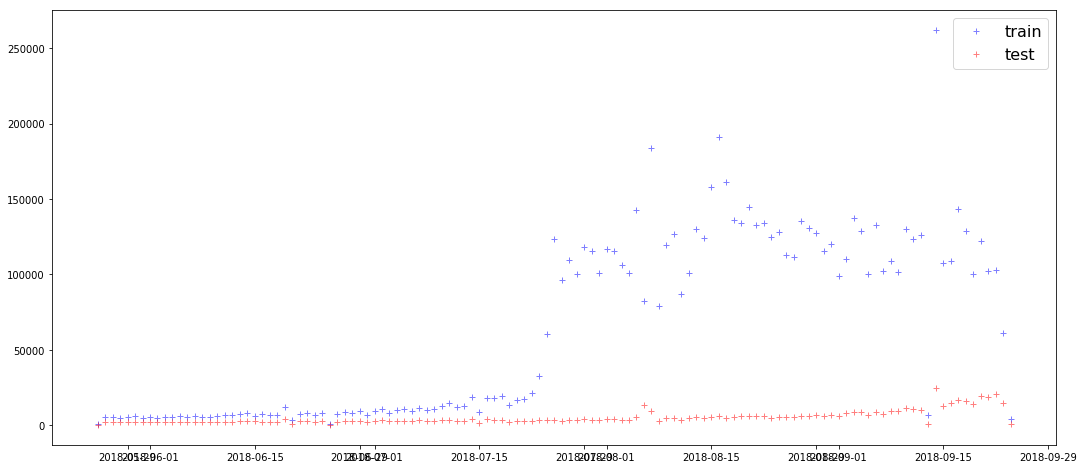

In [189]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['size'], '+', color='b', alpha=0.5, label='train')
plt.plot(te_temp.Date_YMD, te_temp['size'], '+', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

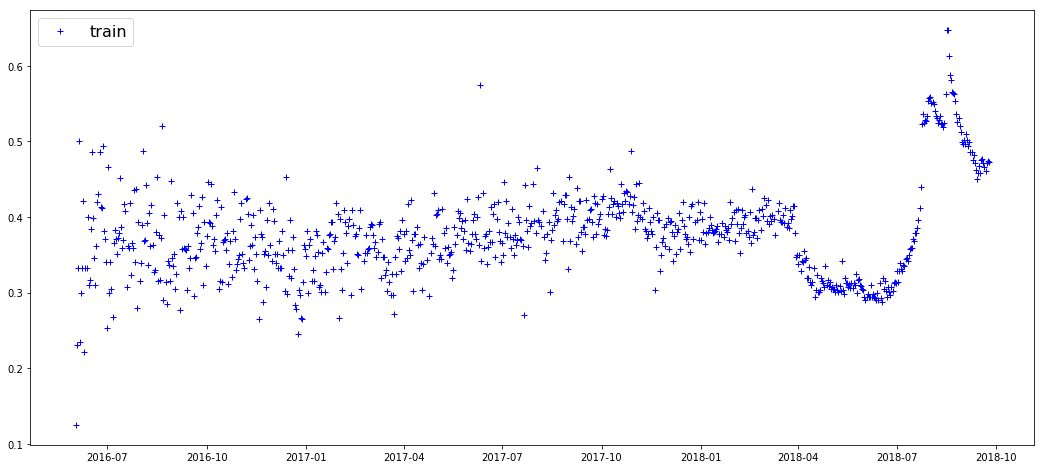

In [270]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['mean'], '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

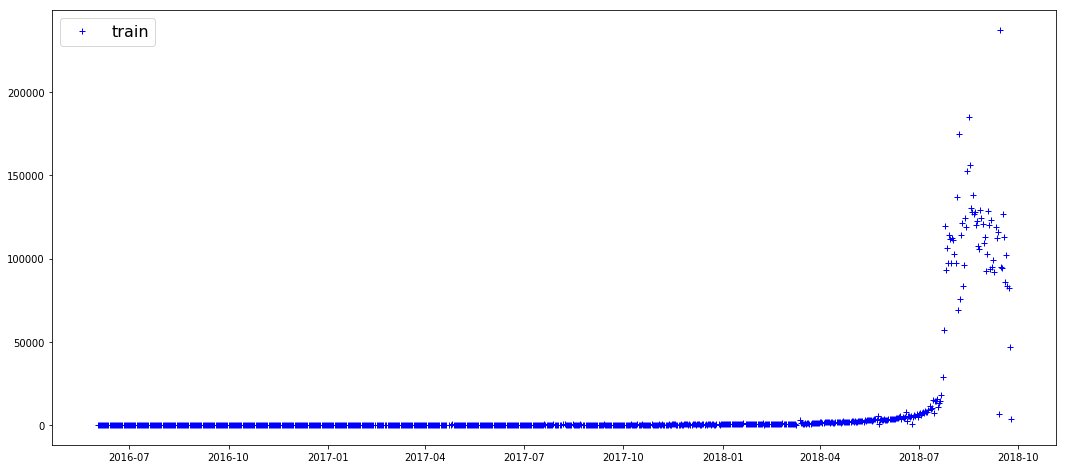

In [293]:
plt.figure(figsize=(18, 8))
plt.plot(te_temp.Date_YMD, tr_temp['size'] - te_temp['size'], '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

In [115]:
base = pd.read_csv('./data/submission_lgb.csv')

In [116]:
base['Date'] = data[data.HasDetections.isna()].Date_YMD.values

In [117]:
base_temp = base.groupby('Date').HasDetections.agg(['size', 'mean']).reset_index()

In [118]:
base_temp = temp.merge(base_temp, left_on='Date_YMD', right_on='Date', how='left')#.fillna(0)

In [119]:
condition = (base_temp.Date_YMD >= '2018-07-25')&(base_temp.Date_YMD <= '2018-09-24') & (base_temp.Date_YMD != '2018-03-01') & (base_temp.Date_YMD != '2017-02-22') & (base_temp.Date_YMD != '2017-08-24')
base_temp = base_temp[condition]

In [150]:
yh = pd.read_csv('./data/YH_v3_new_jebal.csv')
yh['Date'] = test.Date_YMD.values

In [124]:
yh_temp = yh.groupby('Date').HasDetections.agg(['size', 'mean']).reset_index()

In [125]:
yh_temp = temp.merge(yh_temp, left_on='Date_YMD', right_on='Date', how='left')#.fillna(0)

In [131]:
condition = (tr_temp.Date_YMD >= '2018-07-25')&(tr_temp.Date_YMD <= '2018-09-24') & (tr_temp.Date_YMD != '2018-03-01') & (tr_temp.Date_YMD != '2017-02-22') & (tr_temp.Date_YMD != '2017-08-24')
yh_temp = yh_temp[condition]

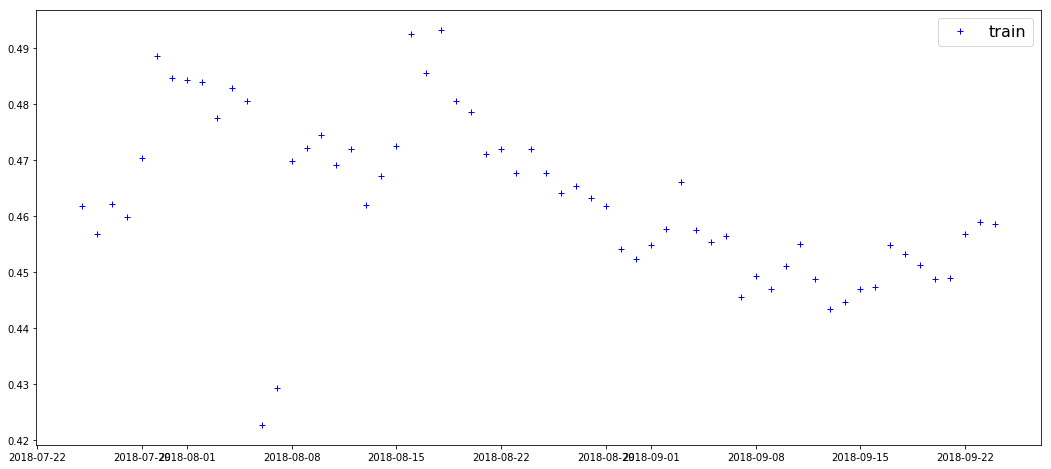

In [132]:
plt.figure(figsize=(18, 8))
plt.plot(yh_temp.Date_YMD, yh_temp['mean'], '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

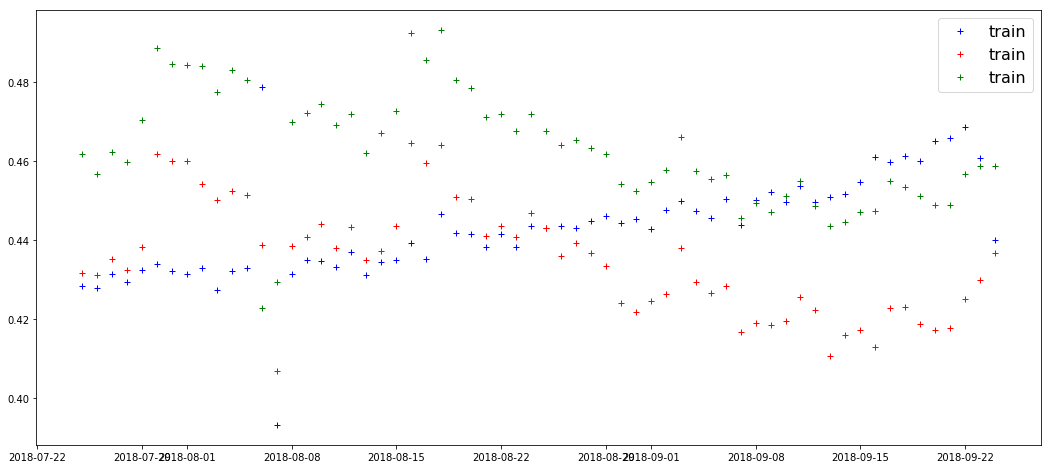

In [133]:
plt.figure(figsize=(18, 8))
plt.plot(base_temp.Date_YMD, base_temp['mean'], '+', color='b', alpha=1, label='train')
plt.plot(tt_temp.Date_YMD, tt_temp['mean'] / 5, '+', color='r', alpha=1, label='train')
plt.plot(yh_temp.Date_YMD, yh_temp['mean'], '+', color='g', alpha=1, label='train')

plt.legend(prop={'size': 16})

In [95]:
tt = test[(test.Date_YMD >= '2018-07-25') & (test.Date_YMD <= '2018-09-24')]

In [97]:
tt.HasDetections = lgb_test_result

In [98]:
tt_temp = tt.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [103]:
tt_temp = temp.merge(tt_temp, left_on='Date_YMD', right_on='Date_YMD', how='left')#.fillna(0)

In [109]:
condition = (tt_temp.Date_YMD >= '2018-07-25')&(tt_temp.Date_YMD <= '2018-09-24')

In [111]:
tt_temp = tt_temp[condition]

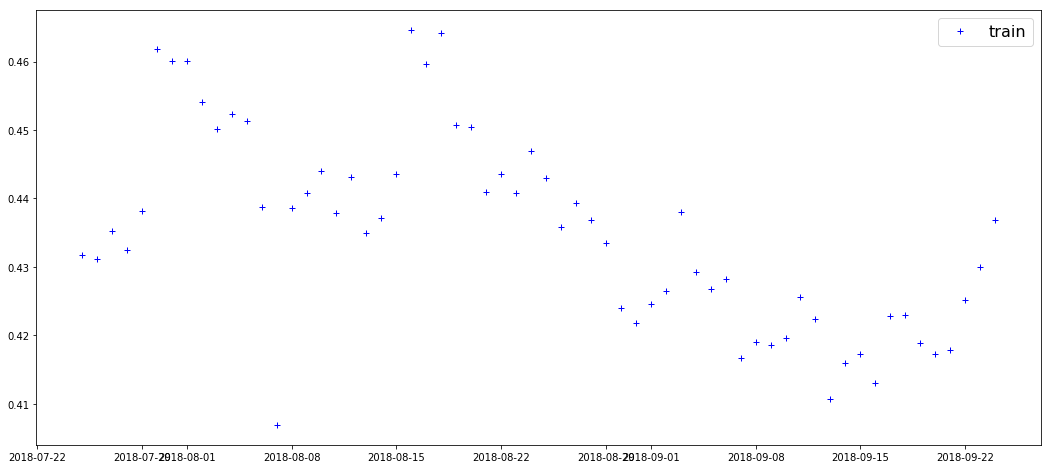

In [113]:
plt.figure(figsize=(18, 8))
plt.plot(tt_temp.Date_YMD, tt_temp['mean'] / 5, '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

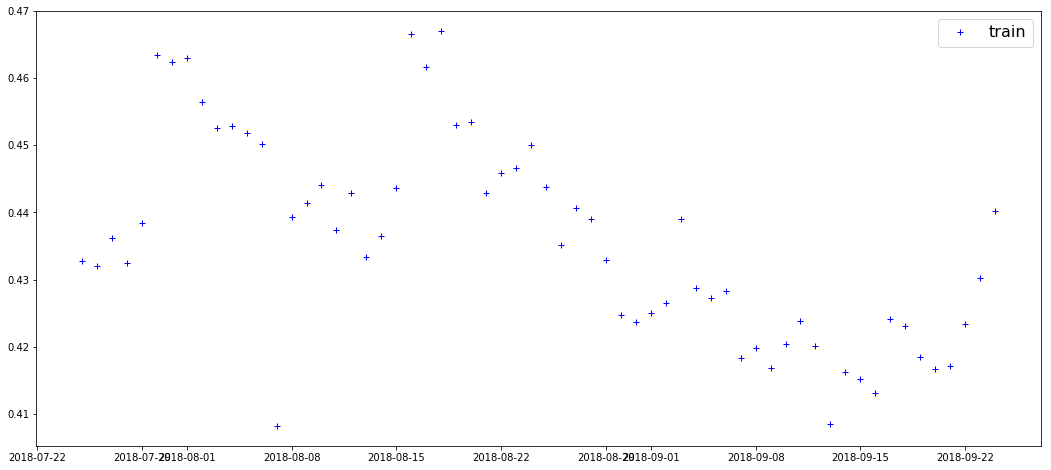

In [89]:
plt.figure(figsize=(18, 8))
plt.plot(tt_temp.Date_YMD, tt_temp['mean'] / 5, '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

In [151]:
tt1 = yh[~ ((yh.Date >= '2018-07-25') & (yh.Date <= '2018-09-24'))]

In [152]:
tt2 = yh[(yh.Date >= '2018-07-25') & (yh.Date <= '2018-09-24')]

In [153]:
tt2.HasDetections = lgb_test_result/5

In [155]:
tt3 = tt1.append(tt2).sort_values('MachineIdentifier')

In [161]:
tt3[['MachineIdentifier', 'HasDetections']].to_csv('./time_test.csv', index=False)

In [156]:
yh['NewHasDetections'] = tt3.HasDetections

In [158]:
yh[['HasDetections', 'NewHasDetections']].corr()

,HasDetections,NewHasDetections
HasDetections,1.000000,0.997104
NewHasDetections,0.997104,1.000000


In [149]:
yh

,MachineIdentifier,HasDetections,Date,NewHasDetections
0,0000010489e3af074adeac69c53e555e,0.506743,2018-11-20,0.506743
1,00000176ac758d54827acd545b6315a5,0.533433,2018-10-22,0.533433
2,0000019dcefc128c2d4387c1273dae1d,0.611486,2018-09-28,0.611486
3,0000055553dc51b1295785415f1a224d,0.342288,2018-11-23,0.342288
4,00000574cefffeca83ec8adf9285b2bf,0.480390,2018-10-21,0.480390
5,000007ffedd31948f08e6c16da31f6d1,0.506531,2018-10-07,0.506531
6,000008f31610018d898e5f315cdf1bd1,0.247400,2018-11-07,0.247400
7,00000a3c447250626dbcc628c9cbc460,0.207781,2018-10-16,0.207781
8,00000b6bf217ec9aef0f68d5c6705897,0.185144,2018-11-23,0.185144
9,00000b8d3776b13e93ad83676a28e4aa,0.317342,2018-04-15,0.317342


In [75]:
tt_temp = temp.merge(tt_temp, left_on='Date_YMD', right_on='Date', how='left')#.fillna(0)

In [69]:
lgb_test_result.shape

(483279,)

In [63]:
(lgb_test_result / 5)

array([0.47843054, 0.37335036, 0.44245162, ..., 0.35585694, 0.40323794,
       0.64202696])

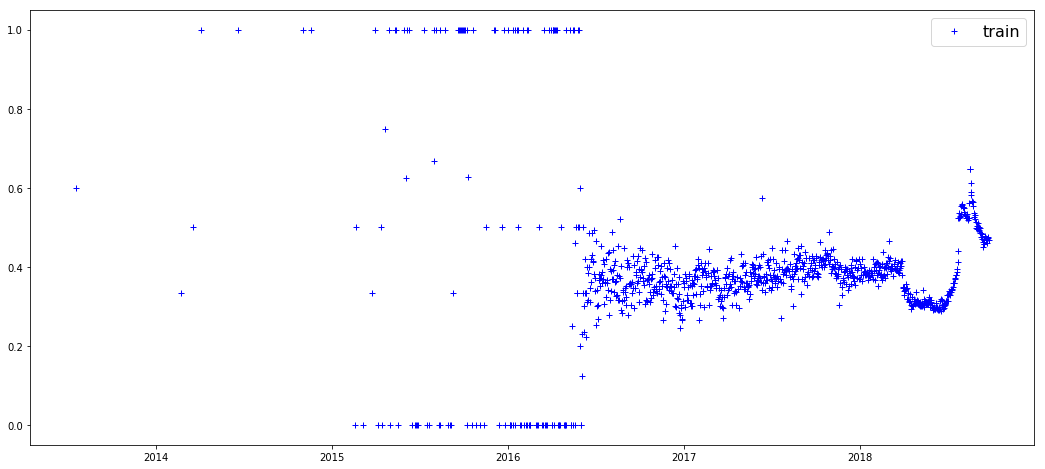

In [162]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['mean'], '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

In [42]:
condition = (tr_temp.Date_YMD >= '2018-09-25')&(tr_temp.Date_YMD <= '2018-11-24') & (tr_temp.Date_YMD != '2018-03-01') & (tr_temp.Date_YMD != '2017-02-22') & (tr_temp.Date_YMD != '2017-08-24')
yh_temp = yh_temp[condition]

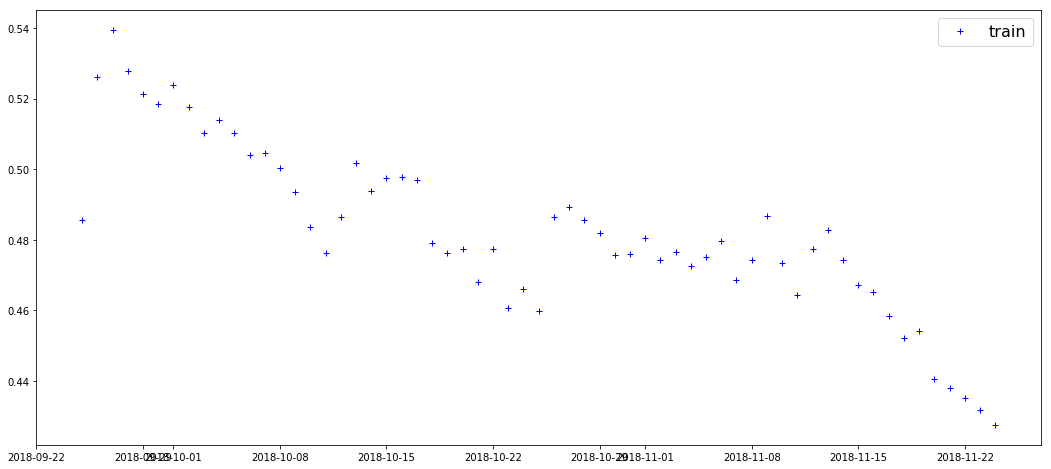

In [43]:
plt.figure(figsize=(18, 8))
plt.plot(yh_temp.Date_YMD, yh_temp['mean'], '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

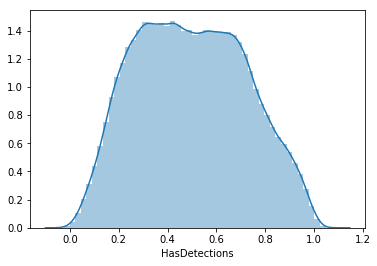

In [289]:
sns.distplot(yh[(yh.Date >= '2016-06-02') & (yh.Date <= '2018-03-24')].HasDetections)

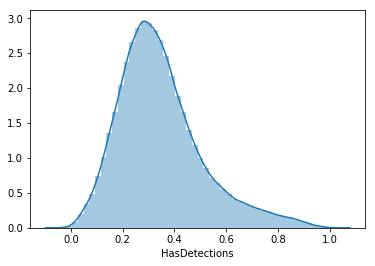

In [291]:
sns.distplot(yh[(yh.Date >= '2018-03-25') & (yh.Date <= '2018-07-24')].HasDetections)

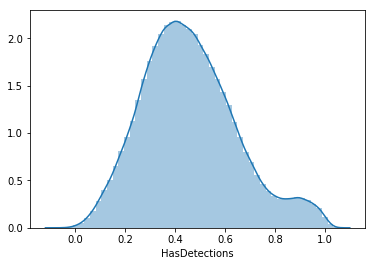

In [292]:
sns.distplot(yh[(yh.Date >= '2018-07-25') & (yh.Date <= '2018-09-24')].HasDetections)

### 2016년 6월 2일 ~ 2018년 3월 24일

In [356]:
temp = data[(data.Date_YMD >= '2016-06-02') & (data.Date_YMD <= '2018-03-24') & (data.Date_YMD != '2018-03-01') & (data.Date_YMD != '2017-02-22') & (data.Date_YMD != '2017-08-24')]
del temp['Date_YMD']

In [322]:
train = temp[~temp.HasDetections.isna()]
test = temp[temp.HasDetections.isna()]

In [323]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [324]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
    
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [325]:
train.shape

(279938, 84)

In [326]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [327]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

14

In [328]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [329]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [330]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [331]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [332]:
del ohe, train, test
gc.collect()

1162

In [333]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [339]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [340]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=100000,
                                   learning_rate=0.01,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=200, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.604836	valid_0's auc: 0.705556
[400]	valid_0's binary_logloss: 0.595105	valid_0's auc: 0.715369
[600]	valid_0's binary_logloss: 0.590745	valid_0's auc: 0.720647
[800]	valid_0's binary_logloss: 0.588484	valid_0's auc: 0.723584
[1000]	valid_0's binary_logloss: 0.587333	valid_0's auc: 0.725067
[1200]	valid_0's binary_logloss: 0.586635	valid_0's auc: 0.725933
[1400]	valid_0's binary_logloss: 0.586229	valid_0's auc: 0.72639
[1600]	valid_0's binary_logloss: 0.585869	valid_0's auc: 0.72684
[1800]	valid_0's binary_logloss: 0.585582	valid_0's auc: 0.727182
[2000]	valid_0's binary_logloss: 0.585349	valid_0's auc: 0.727422
[2200]	valid_0's binary_logloss: 0.585156	valid_0's auc: 0.7276
[2400]	valid_0's binary_logloss: 0.584974	valid_0's auc: 0.727801
[2600]	valid_0's binary_logloss: 0.584803	valid_0's auc: 0.72799
[2800]	valid_0's binary_logloss: 0.584659	valid_0's auc: 0.72

In [363]:
t = data[data.HasDetections.isna()]

In [364]:
t = t.reset_index(drop=True)

In [365]:
t = t[(t.Date_YMD >= '2016-06-02') & (t.Date_YMD <= '2018-03-24') & (t.Date_YMD != '2018-03-01') & (t.Date_YMD != '2017-02-22') & (t.Date_YMD != '2017-08-24')]

In [368]:
idx_4 = t.index

In [371]:
data = pd.read_csv('./data_temp/outlier_split.csv')

In [381]:
lgb_test_result/10

array([0.29278682, 0.32002471, 0.31088769, ..., 0.41186347, 0.14429379,
       0.78599876])

In [382]:
root[idx_4] = lgb_test_result/10

In [386]:
pd.DataFrame(root).to_csv('./data_temp/outlier_split.csv', index=False)

## 그 외

In [67]:
temp = data[(data.Date_YMD >= '2018-07-25') & (data.Date_YMD <= '2018-09-24')]
temp.drop(['Date'], inplace=True, axis=1)

In [68]:
train = temp[~temp.HasDetections.isna()]
test = temp[temp.HasDetections.isna()]

In [69]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [10]:
train.shape

(7332401, 84)

In [11]:
test.shape

(483279, 84)

In [23]:
train['Score'] = train.Date_YMD
test['Score'] = test.Date_YMD

In [27]:
train.Score = train.Score.map(train.groupby(['Date_YMD']).HasDetections.mean())
test.Score = test.Score.map(train.groupby(['Date_YMD']).HasDetections.mean())

In [31]:
del temp, data
gc.collect()

14

In [33]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier', 'Score']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)

    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] / 12 + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / (agg['Total'] * 12) > 0.2) & (agg['Train'] / (agg['Total'] * 12) < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
        
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [35]:
train.shape

(7332401, 85)

In [36]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [37]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

14

In [38]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [17]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [41]:
# categorical features
cat_features = train.dtypes[(train.dtypes == 'category')].index.tolist()

In [45]:
ct = ColumnTransformer([('categorical', OneHotEncoder(categories='auto', sparse=True), cat_features),
                        ('numerical', 'passthrough', ['Score'])],
                       sparse_threshold=1).fit(train.append(test))

In [46]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ct.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ct.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [18]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [47]:
train.shape

(7332401, 7251)

In [48]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [50]:
del ct, train, test
gc.collect()

225

In [51]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [52]:
train.shape

(7332401, 7251)

In [53]:
test.shape

(483279, 7251)

In [54]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [55]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.05,
                                   num_leaves=2**12-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=10, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[10]	valid_0's binary_logloss: 0.647815	valid_0's auc: 0.717196
[20]	valid_0's binary_logloss: 0.626858	valid_0's auc: 0.719718
[30]	valid_0's binary_logloss: 0.616283	valid_0's auc: 0.722503
[40]	valid_0's binary_logloss: 0.610215	valid_0's auc: 0.724945
[50]	valid_0's binary_logloss: 0.606542	valid_0's auc: 0.727115
[60]	valid_0's binary_logloss: 0.603803	valid_0's auc: 0.729106
[70]	valid_0's binary_logloss: 0.601759	valid_0's auc: 0.730905
[80]	valid_0's binary_logloss: 0.600096	valid_0's auc: 0.732481
[90]	valid_0's binary_logloss: 0.598849	valid_0's auc: 0.733765
[100]	valid_0's binary_logloss: 0.597802	valid_0's auc: 0.73485
[110]	valid_0's binary_logloss: 0.596929	valid_0's auc: 0.735781
[120]	valid_0's binary_logloss: 0.596116	valid_0's auc: 0.736654
[130]	valid_0's binary_logloss: 0.595478	valid_0's auc: 0.737347
[140]	valid_0's binary_logloss: 0.594985	valid_0's auc: 0.737877
[150]	vali

In [32]:
pd.DataFrame(lgb_test_result/5).to_csv('./data_temp/real_temp.csv')

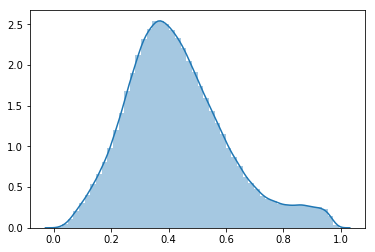

In [56]:
sns.distplot(lgb_test_result/5)